In [1]:
import pandas as pd
import re

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
import tensorflow_text as text

In [3]:
import tensorflow_hub as hub

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
val = pd.read_csv("data/valid.csv")

In [5]:
def build_classifier_model(number_classes):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(number_classes, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [6]:
def execute_model(X_train, y_train, X_test, y_test, epochs):

    #we use label encoding to convert text labels to numeric, we go from ineffective -> 0 for example


    #we then need to convert the values to tensors, ensuring that the values are converted to strings.
    X_train = tf.convert_to_tensor(X_train.map(str))
    y_train = tf.convert_to_tensor(y_train)
    X_test = tf.convert_to_tensor(X_test.map(str))
    y_test = tf.convert_to_tensor(y_test)

    #extract the number of classes
    number_classes = len(set(y_train.numpy()))

    #build the model
    classifier_model = build_classifier_model(number_classes)
    #we use adam optimizer, as it is an industry standard, and the loss as sparse categorical crossentropy, as our labels are not one-hot encoded.
    classifier_model.compile(optimizer="adam",
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    #we can then train the model
    print(f'Training model:')
    history = classifier_model.fit(X_train, y_train,
                               epochs=epochs)

    #evaluate the model
    print("Evaluating accuracy:")
    loss, accuracy = classifier_model.evaluate(X_test, y_test)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    #predict for the test data
    prediction = classifier_model.predict(X_test)
    y_pred = []
    for class_pos in prediction.argmax(axis=1):
        y_pred.append(class_pos)


    #show the f1 score and confusion matrix
    print(f"weighted f1-score:{f1_score(y_test, y_pred, average='weighted')}")

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    fig = sns.heatmap(df_cm, annot=True, fmt='g')
    fig.set(xlabel='Predicted', ylabel='Actual')

# BERT

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


2022-02-01 14:13:16.467499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 14:13:16.472135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-02-01 14:13:16.474370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-01 14:13:16.474417: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required

In [8]:
X_train, y_train = train.clean_text, train.label
X_test, y_test = test.clean_text, test.label

Training model:
Epoch 1/5
102/102 [==============================] - 50s 441ms/step - loss: 1.0689 - acc: 0.5723
Epoch 2/5
102/102 [==============================] - 42s 409ms/step - loss: 0.5746 - acc: 0.8038
Epoch 3/5
102/102 [==============================] - 42s 414ms/step - loss: 0.3327 - acc: 0.8962
Epoch 4/5
102/102 [==============================] - 42s 413ms/step - loss: 0.1887 - acc: 0.9407
Epoch 5/5
102/102 [==============================] - 42s 416ms/step - loss: 0.1169 - acc: 0.9607
Evaluating accuracy:
45/45 [==============================] - 6s 126ms/step - loss: 1.2331 - acc: 0.6958
Loss: 1.233130931854248
Accuracy: 0.6957746744155884
weighted f1-score:0.6977170717673256


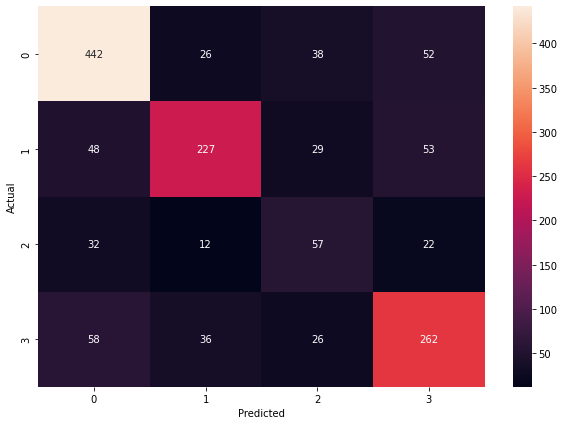

In [9]:
execute_model(X_train, y_train, X_test, y_test, 5)

## Roberta

In [10]:
robert_preprocess_model = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1")

robert_model = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-24_H-1024_A-16/1", trainable=True)

2022-02-01 14:17:36.374158: I external/com_google_sentencepiece/src/normalizer.cc:51] precompiled_charsmap is empty. use identity normalization.
2022-02-01 14:18:59.953685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205885440 exceeds 10% of free system memory.


Training model:
Epoch 1/5
102/102 [==============================] - 47s 417ms/step - loss: 1.0689 - acc: 0.5536
Epoch 2/5
102/102 [==============================] - 42s 408ms/step - loss: 0.6265 - acc: 0.7820
Epoch 3/5
102/102 [==============================] - 44s 429ms/step - loss: 0.4049 - acc: 0.8631
Epoch 4/5
102/102 [==============================] - 44s 436ms/step - loss: 0.2558 - acc: 0.9143
Epoch 5/5
102/102 [==============================] - 40s 395ms/step - loss: 0.1657 - acc: 0.9450
Evaluating accuracy:
45/45 [==============================] - 4s 83ms/step - loss: 1.2108 - acc: 0.6704
Loss: 1.2107940912246704
Accuracy: 0.6704225540161133
weighted f1-score:0.6686625197425439


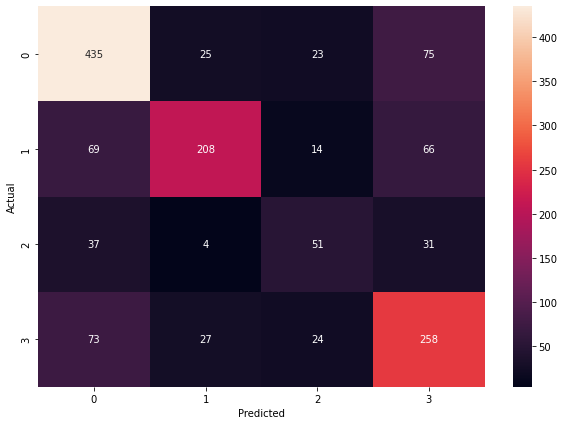

In [11]:
X_train, y_train = train.clean_text, train.label
X_test, y_test = test.clean_text, test.label
execute_model(X_train, y_train, X_test, y_test, 5)